In [1]:
from matplotlib import pyplot as plt
%matplotlib widget
import matplotlib
matplotlib.use('nbagg')
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams.update({'font.size': 14})
# matplotlib.rcParams.update({'font.family': 'serif'})
# matplotlib.rcParams.update({'text.latex.preamble': 
#                             r'\usepackage[russian]{babel}\usepackage{amsmath}'})

In [2]:
import numpy as np
freqs = frequencies = np.linspace(18, 27.2, 47)

## load dumps

In [3]:
import numpy as np
import os

TS = np.load(os.path.join('dump', 'ts.npy'))
DT = np.load(os.path.join('dump', 'dt.npy'))
BT = np.load(os.path.join('dump', 'bt.npy'))
LM = np.load(os.path.join('dump', 'lm.npy'))
MS = np.load(os.path.join('dump', 'ms.npy'))
ID = np.load(os.path.join('dump', 'id.npy'))
QREAL = np.load(os.path.join('dump', 'qreal.npy'))

print(
    TS.shape, TS.dtype, '\n',
    DT.shape, DT.dtype, '\n',
    ID.shape, ID.dtype, '\n',
    BT.shape, BT.dtype, '\n',
    LM.shape, LM.dtype, '\n',
    MS.shape, MS.dtype, '\n',
)

(8170376,) float64 
 (8170376, 7) int64 
 (8170376,) int64 
 (8170376, 47) float32 
 (8170376, 5) float32 
 (8170376, 4) int64 



## prepare 00pm

In [ ]:
cond = ((DT[:, 3] == 11) & (DT[:, 4] > 59)) | ((DT[:, 3] == 12) & (DT[:, 4] < 1))

In [ ]:
ts, dt, id_, bt, lm, ms, qreal = \
    TS[cond], DT[cond], ID[cond], BT[cond], LM[cond], MS[cond], QREAL[cond]
ts.shape

In [ ]:
path_to_dump_dir = os.path.join('dump', '00pm')
if not os.path.exists(path_to_dump_dir):
    os.makedirs(path_to_dump_dir)

np.save(os.path.join(path_to_dump_dir, 'ts.npy'), ts)
np.save(os.path.join(path_to_dump_dir, 'dt.npy'), dt)
np.save(os.path.join(path_to_dump_dir, 'id.npy'), id_)
np.save(os.path.join(path_to_dump_dir, 'bt.npy'), bt)
np.save(os.path.join(path_to_dump_dir, 'lm.npy'), lm)
np.save(os.path.join(path_to_dump_dir, 'ms.npy'), ms)
np.save(os.path.join(path_to_dump_dir, 'qreal.npy'), qreal)

## prepare 00am

In [ ]:
cond = ((DT[:, 3] == 23) & (DT[:, 4] > 59)) | ((DT[:, 3] == 0) & (DT[:, 4] < 1))

In [ ]:
ts, dt, id_, bt, lm, ms, qreal = \
    TS[cond], DT[cond], ID[cond], BT[cond], LM[cond], MS[cond], QREAL[cond]
ts.shape

In [ ]:
path_to_dump_dir = os.path.join('dump', '00am')
if not os.path.exists(path_to_dump_dir):
    os.makedirs(path_to_dump_dir)

np.save(os.path.join(path_to_dump_dir, 'ts.npy'), ts)
np.save(os.path.join(path_to_dump_dir, 'dt.npy'), dt)
np.save(os.path.join(path_to_dump_dir, 'id.npy'), id_)
np.save(os.path.join(path_to_dump_dir, 'bt.npy'), bt)
np.save(os.path.join(path_to_dump_dir, 'lm.npy'), lm)
np.save(os.path.join(path_to_dump_dir, 'ms.npy'), ms)
np.save(os.path.join(path_to_dump_dir, 'qreal.npy'), qreal)

## compute tau

In [ ]:
# $ python prepare_tau.py -P './dump/00pm/'
# OR
# $ python prepare_tau.py -P './dump/00am/'

##  train on 00 pm

In [4]:
import sys
sys.path.append('../atmrad')

from cpu.atmosphere import Atmosphere, avg
from cpu.weight_funcs import krho
from cpu.core.static.weight_funcs import kw

In [5]:
cond = ((DT[:, 3] == 11) & (DT[:, 4] > 59)) | ((DT[:, 3] == 12) & (DT[:, 4] < 1))
ts, dt, id_, bt, lm, ms, qreal = \
    TS[cond], DT[cond], ID[cond], BT[cond], LM[cond], MS[cond], QREAL[cond]
ts.shape

(5558,)

In [6]:
tau = np.load(os.path.join(os.path.join('dump', '00pm'), 'tau.npy'))
tau.shape

(5558, 47)

In [7]:
tau_model_w0 = []
tau_model = []
WSTD = []

for i, (T0, P0, rho0, *_) in enumerate(lm):
    atm = Atmosphere.Standard(T0, P0, rho0, H=15, dh=15 / 1000.)
    
    tau_o_model = np.asarray([atm.opacity.oxygen(nu) for nu in frequencies])
    k_rho = np.asarray([krho(atm, nu) for nu in frequencies])
    k_w = np.asarray([kw(nu, t=0.) for nu in frequencies])
    
    tau_model_w0.append(tau_o_model + k_rho * qreal[i] + k_w * 0.)
    
    W = (tau[i] - tau_o_model - k_rho * qreal[i]) / k_w
    
    W = np.mean(W)
    if W < 0:
        W = 0.
    
    tau_model.append(tau_o_model + k_rho * qreal[i] + k_w * W)
    
    WSTD.append(W)
    
    print('\r{:.2f}%'.format((i + 1) / len(lm) * 100.), end='    ', flush=True)
    
tau_model_w0 = np.asarray(tau_model_w0)
tau_model = np.asarray(tau_model)
WSTD = np.asarray(WSTD)

100.00%                   

<IPython.core.display.Javascript object>


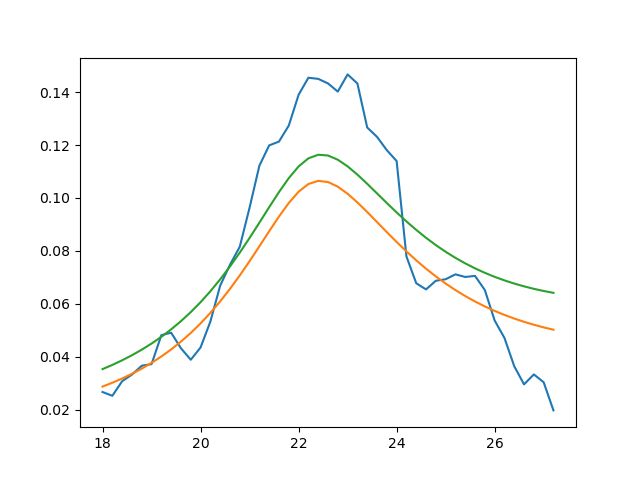

0.08411078903184331

In [8]:
plt.figure()
i = 60
plt.plot(frequencies, tau[i, :])
plt.plot(frequencies, tau_model_w0[i, :])
plt.plot(frequencies, tau_model[i, :])
WSTD[i]

In [9]:
X = np.hstack((tau, (lm[:, 0].reshape(-1, 1) - (-30)) / (40 - (-30)),
                    (lm[:, 1].reshape(-1, 1) - 900) / (1100 - 900),
                     lm[:, 2].reshape(-1, 1) / 30.
              ))
X.shape

(5558, 50)

In [10]:
y = np.vstack((qreal, WSTD)).T
y.shape

(5558, 2)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

regr_mlp_00pm = MLPRegressor(
    hidden_layer_sizes=(100,50,), 
    activation='logistic',
    random_state=42,
    max_iter=500,
#     verbose=True,
)

regr_mlp_00pm = regr_mlp_00pm.fit(X_train, y_train)

In [ ]:
regr_mlp_00pm.score(X_test, y_test)

In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

regr_mlp_00pm = MLPRegressor(
    hidden_layer_sizes=(100,50,), 
    activation='logistic',
    random_state=42,
    max_iter=500,
#     verbose=True,
)

regr_mlp_00pm = regr_mlp_00pm.fit(X, y)

In [12]:
regr_mlp_00pm.score(X, y)

0.9621351593010574

In [13]:
pred = regr_mlp_00pm.predict(np.hstack((tau, (lm[:, 0].reshape(-1, 1) - (-30)) / (40 - (-30)),
                                 (lm[:, 1].reshape(-1, 1) - 900) / (1100 - 900),
                                  lm[:, 2].reshape(-1, 1) / 30.
                           ))
                 )
Q, W = pred[:, 0], pred[:, 1]

<IPython.core.display.Javascript object>


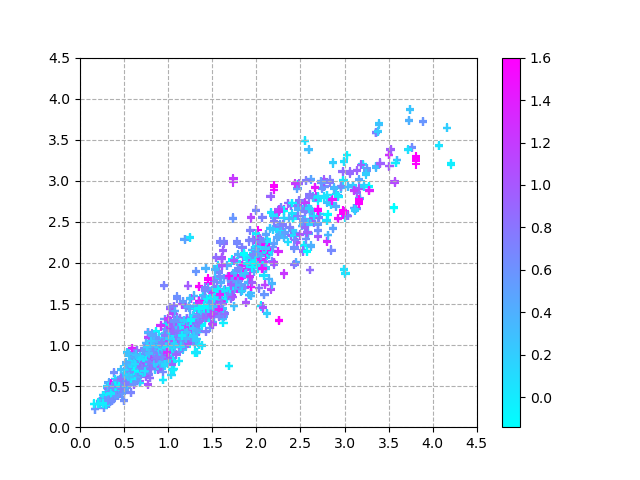

(0.0, 4.5)

In [14]:
plt.figure()

lim = 1.6
plt.scatter(qreal, Q, marker='+', c=np.where(W > lim, lim, W), cmap='cool' )
plt.colorbar()
plt.grid(linestyle='--')
plt.xlim((0, 4.5))
plt.ylim((0, 4.5))

## predict 00 am

In [15]:
cond = ((DT[:, 3] == 23) & (DT[:, 4] > 59)) | ((DT[:, 3] == 0) & (DT[:, 4] < 1))
ts, dt, id_, bt, lm, ms, qreal = \
    TS[cond], DT[cond], ID[cond], BT[cond], LM[cond], MS[cond], QREAL[cond]
ts.shape

(5782,)

In [16]:
tau = np.load(os.path.join(os.path.join('dump', '00am'), 'tau.npy'))
tau.shape

(5782, 47)

In [17]:
pred = regr_mlp_00pm.predict(np.hstack((tau, (lm[:, 0].reshape(-1, 1) - (-30)) / (40 - (-30)),
                                 (lm[:, 1].reshape(-1, 1) - 900) / (1100 - 900),
                                  lm[:, 2].reshape(-1, 1) / 30.
                           ))
                 )
Q, W = pred[:, 0], pred[:, 1]
Q.shape

(5782,)

In [ ]:
plt.figure()
lim = 1.6
plt.scatter(qreal, Q, marker='+', c=np.where(W > lim, lim, W), cmap='cool' )
plt.colorbar()
plt.grid(linestyle='--')
plt.xlim((0, 4.5))
plt.ylim((0, 4.5))

<IPython.core.display.Javascript object>


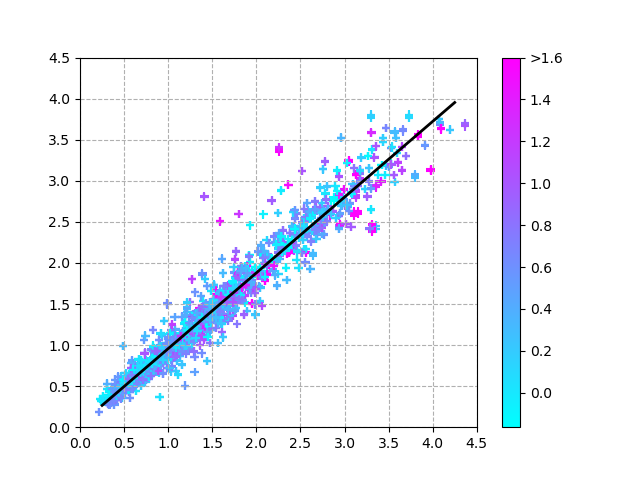

/tmp/ipykernel_52919/463735724.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2', '1.4', '>1.6'])


0.9221887


In [18]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(qreal.reshape(-1, 1), Q)
x = np.linspace(np.min(qreal), np.max(qreal), len(qreal))
y_pred = regr.predict(x.reshape(-1, 1))

fig, ax = plt.subplots()
lim = 1.6
cax = ax.scatter(qreal, Q, marker='+', c=np.where(W > lim, lim, W), cmap='cool' )
cbar = fig.colorbar(cax)
cbar.ax.set_yticklabels(['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2', '1.4', '>1.6'])
plt.plot(x[(x >= 0.25) & (x <= 4.25)], y_pred[(x >= 0.25) & (x <= 4.25)], color='black', linewidth=2)
plt.grid(linestyle='--')
plt.xlim((0, 4.5))
plt.ylim((0, 4.5))

plt.savefig('train_00pm_predict_00am.png', dpi=300)
print(regr.coef_[0])

## train on 00 am

In [19]:
import sys
sys.path.append('../atmrad')

from cpu.atmosphere import Atmosphere, avg
from cpu.weight_funcs import krho
from cpu.core.static.weight_funcs import kw

In [20]:
cond = ((DT[:, 3] == 23) & (DT[:, 4] > 59)) | ((DT[:, 3] == 0) & (DT[:, 4] < 1))
ts, dt, id_, bt, lm, ms, qreal = \
    TS[cond], DT[cond], ID[cond], BT[cond], LM[cond], MS[cond], QREAL[cond]
ts.shape

(5782,)

In [21]:
tau = np.load(os.path.join(os.path.join('dump', '00am'), 'tau.npy'))
tau.shape

(5782, 47)

In [22]:
tau_model_w0 = []
tau_model = []
WSTD = []

for i, (T0, P0, rho0, *_) in enumerate(lm):
    atm = Atmosphere.Standard(T0, P0, rho0, H=15, dh=15 / 1000.)
    
    tau_o_model = np.asarray([atm.opacity.oxygen(nu) for nu in frequencies])
    k_rho = np.asarray([krho(atm, nu) for nu in frequencies])
    k_w = np.asarray([kw(nu, t=0.) for nu in frequencies])
    
    tau_model_w0.append(tau_o_model + k_rho * qreal[i] + k_w * 0.)
    
    W = (tau[i] - tau_o_model - k_rho * qreal[i]) / k_w
    
    W = np.mean(W)
    if W < 0:
        W = 0.
    
    tau_model.append(tau_o_model + k_rho * qreal[i] + k_w * W)
    
    WSTD.append(W)
    
    print('\r{:.2f}%'.format((i + 1) / len(lm) * 100.), end='    ', flush=True)
    
tau_model_w0 = np.asarray(tau_model_w0)
tau_model = np.asarray(tau_model)
WSTD = np.asarray(WSTD)

100.00%                                                                              

<IPython.core.display.Javascript object>


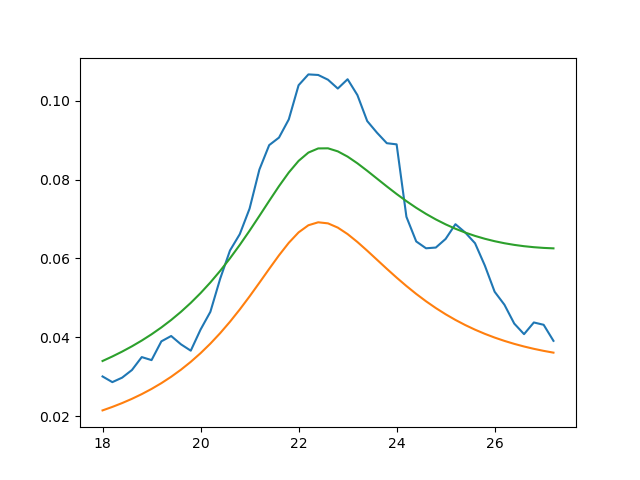

0.15988812449528522

In [23]:
plt.figure()
i = 60
plt.plot(frequencies, tau[i, :])
plt.plot(frequencies, tau_model_w0[i, :])
plt.plot(frequencies, tau_model[i, :])
WSTD[i]

In [24]:
X = np.hstack((tau, (lm[:, 0].reshape(-1, 1) - (-30)) / (40 - (-30)),
                    (lm[:, 1].reshape(-1, 1) - 900) / (1100 - 900),
                     lm[:, 2].reshape(-1, 1) / 30.
              ))
X.shape

(5782, 50)

In [25]:
y = np.vstack((qreal, WSTD)).T
y.shape

(5782, 2)

In [26]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

regr_mlp_00am = MLPRegressor(
    hidden_layer_sizes=(100,50,), 
    activation='logistic',
    random_state=42,
    max_iter=500,
#     verbose=True,
)

regr_mlp_00am = regr_mlp_00am.fit(X, y)

In [27]:
regr_mlp_00am.score(X, y)

0.9599849129998324

In [28]:
pred = regr_mlp_00am.predict(np.hstack((tau, (lm[:, 0].reshape(-1, 1) - (-30)) / (40 - (-30)),
                                 (lm[:, 1].reshape(-1, 1) - 900) / (1100 - 900),
                                  lm[:, 2].reshape(-1, 1) / 30.
                           ))
                 )
Q, W = pred[:, 0], pred[:, 1]

<IPython.core.display.Javascript object>


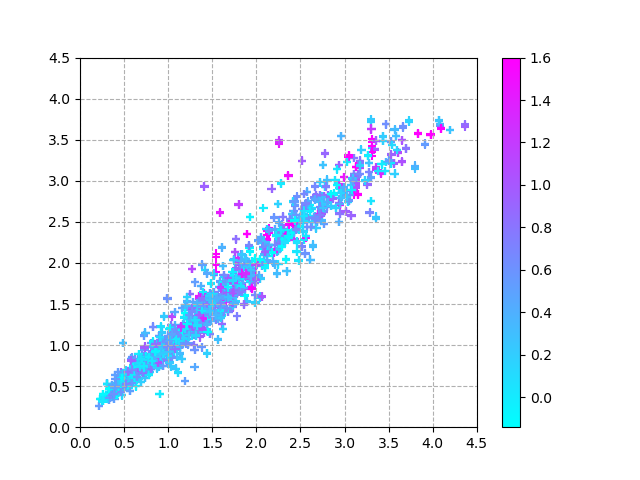

(0.0, 4.5)

In [29]:
plt.figure()

lim = 1.6
plt.scatter(qreal, Q, marker='+', c=np.where(W > lim, lim, W), cmap='cool' )
plt.colorbar()
plt.grid(linestyle='--')
plt.xlim((0, 4.5))
plt.ylim((0, 4.5))

## predict 00 pm

In [30]:
cond = ((DT[:, 3] == 11) & (DT[:, 4] > 59)) | ((DT[:, 3] == 12) & (DT[:, 4] < 1))
ts, dt, id_, bt, lm, ms, qreal = \
    TS[cond], DT[cond], ID[cond], BT[cond], LM[cond], MS[cond], QREAL[cond]
ts.shape

(5558,)

In [31]:
tau = np.load(os.path.join(os.path.join('dump', '00pm'), 'tau.npy'))
tau.shape

(5558, 47)

In [32]:
pred = regr_mlp_00am.predict(np.hstack((tau, (lm[:, 0].reshape(-1, 1) - (-30)) / (40 - (-30)),
                                 (lm[:, 1].reshape(-1, 1) - 900) / (1100 - 900),
                                  lm[:, 2].reshape(-1, 1) / 30.
                           ))
                 )
Q, W = pred[:, 0], pred[:, 1]
Q.shape

(5558,)

<IPython.core.display.Javascript object>


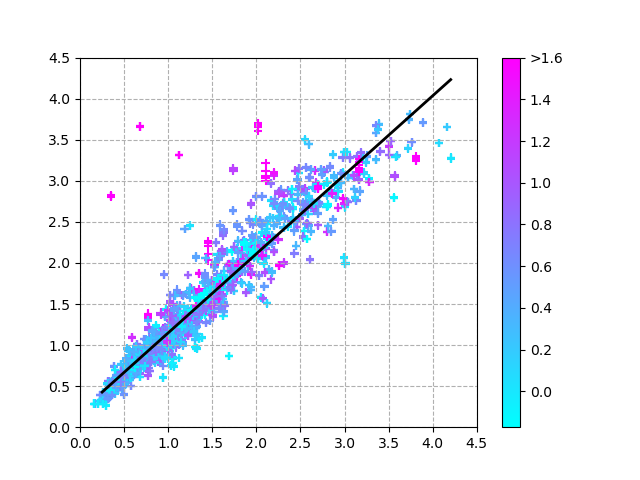

/tmp/ipykernel_52919/3014227010.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2', '1.4', '>1.6'])


0.9624203


In [33]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(qreal.reshape(-1, 1), Q)
x = np.linspace(np.min(qreal), np.max(qreal), len(qreal))
y_pred = regr.predict(x.reshape(-1, 1))

fig, ax = plt.subplots()
lim = 1.6
cax = ax.scatter(qreal, Q, marker='+', c=np.where(W > lim, lim, W), cmap='cool' )
cbar = fig.colorbar(cax)
cbar.ax.set_yticklabels(['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2', '1.4', '>1.6'])
plt.plot(x[(x >= 0.25) & (x <= 4.25)], y_pred[(x >= 0.25) & (x <= 4.25)], color='black', linewidth=2)
plt.grid(linestyle='--')
plt.xlim((0, 4.5))
plt.ylim((0, 4.5))

plt.savefig('train_00am_predict_00pm.png', dpi=300)
print(regr.coef_[0])